### Mouse Protein

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
import contrastive_inverse_regression
from contrastive_inverse_regression import CIR


data = pd.read_csv('Data_Cortex_Nuclear.csv')


# foreground data
fg = data.dropna()

# foreground label
Y = fg['class']
Y = pd.Categorical(Y)
Y = Y.rename_categories({'c-CS-m': '0', 'c-CS-s': '1', 'c-SC-m': '2', 'c-SC-s': '3',
                         't-CS-m': '4', 't-CS-s': '5', 't-SC-m': '6', 't-SC-s': '7'})
Y = Y.astype(float)
labels = np.unique(Y)      # set of unique foreground labels

# foreground slices
L = len(labels)         # number of foreground classes/slices
fg = fg.iloc[:, 1:78]
n = fg.shape[0]  # foreground sample size
X = fg - np.mean(fg, axis=0)
X = X.values

# background data
bg = data[data['Genotype'] == 'Control'].copy()
bg = bg.dropna()

# background label
Yt = bg['Behavior']
Yt = pd.Categorical(Yt)
Yt = Yt.rename_categories({'C/S': '0', 'S/C': '1'})
Yt = Yt.astype(float)
labelst = np.unique(Yt)   # set of unique background labels
Lt = len(labelst)       # number of background classes/slices
bg = bg.iloc[:, 1:78]
m, p = bg.shape

# tuning parameter
alpha = 0.0002
d = 2

print("CIR......")
accurary_group = []


for i in range(1):
    V_CIR = CIR(fg, Y, bg, Yt, alpha, d)
    X_CIR = X @ V_CIR
    mdl_CIR_KNN = KNeighborsClassifier(n_neighbors=1)
    # kf = KFold(n_splits=10)
    # kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cross_val_results = cross_val_score(
        mdl_CIR_KNN, X_CIR, Y, cv=10, scoring='accuracy')
    print(cross_val_results)
    Accuracy_CIR_KNN = np.mean(cross_val_results)
    accurary_group.append(Accuracy_CIR_KNN)

print("this is CIR_KNN ", accurary_group)
print("This is mean ", np.mean(accurary_group))
print("This is standard deviation", np.std(accurary_group))


accurary_group_tree = []

for i in range(1):
    V_CIR = CIR(fg, Y, bg, Yt, alpha, d)
    X_CIR = X @ V_CIR
    mdl_CIR_Tree = DecisionTreeClassifier()
    # kf = KFold(n_splits=10)
    # kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cross_val_results = cross_val_score(
        mdl_CIR_Tree, X_CIR, Y, cv=10, scoring='accuracy')
    print(cross_val_results)
    Accuracy_CIR_Tree = cross_val_results.mean()
    accurary_group_tree.append(Accuracy_CIR_Tree)

print("this is CIR_Tree ", accurary_group_tree)
print("This is mean ", np.mean(accurary_group_tree))
print("This is standard deviation ", np.std(accurary_group_tree))


CIR......


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


---------------------------------------------------

Results for Scaled Gradient Projection Method 

---------------------------------------------------

   Obj. function = 2.411549e+00

   Gradient norm = 1.740218e-04 

   ||X^T*X-I||_F = 4.97e-16

   Iteration number = 3000

   Cpu time (secs) = 4.0590

   Number of evaluation(Obj. func) = 3468

[0.839285714285714 0.75              0.781818181818182 0.727272727272727
 0.545454545454545 0.618181818181818 0.745454545454545 0.6
 0.727272727272727 0.836363636363636]
this is CIR_KNN  [0.7171103896103896]
This is mean  0.7171103896103896
This is standard deviation 0.0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


---------------------------------------------------

Results for Scaled Gradient Projection Method 

---------------------------------------------------

   Obj. function = 2.411605e+00

   Gradient norm = 1.338660e-04 

   ||X^T*X-I||_F = 4.97e-16

   Iteration number = 3000

   Cpu time (secs) = 9.1203

   Number of evaluation(Obj. func) = 3244

[0.785714285714286 0.767857142857143 0.781818181818182 0.581818181818182
 0.618181818181818 0.672727272727273 0.709090909090909 0.672727272727273
 0.672727272727273 0.8              ]
this is CIR_Tree  [0.7062662337662338]
This is mean  0.7062662337662338
This is standard deviation  0.0


In [3]:
import numpy as np
import pandas as pd
import time
import scipy
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import Lasso
from sklearn.manifold import TSNE
import umap

import contrastive_inverse_regression
from contrastive_inverse_regression import CIR


data = pd.read_csv('pbmc_1_counts.csv')
data = data.iloc[:, 1:]
data = data.transpose()


cell_type = pd.read_csv('pbmc_1_cell_type.csv')
cell_type = cell_type.iloc[:, 1].values


# foreground data
fg = data.dropna()


p = 100     # p can vary from 100 to 500
# select the top p highly variable genes
col_var = np.var(fg, axis=0)
col_var_sorted_idx = np.argsort(-col_var)
fg = fg.iloc[:, col_var_sorted_idx[:p]]


# foreground label: cell types
Y = cell_type
Y = pd.Categorical(Y)
Y = Y.rename_categories({'B cell': '0', 'CD4 T cell': '1', 'CD8 T cell': '2', 'NK cell': '3',
                        'Plasma cell': '4', 'cDC': '5', 'cMono': '6', 'ncMono': '7', 'pDC': '8'})
Y = Y.astype(float)
labels = np.unique(Y)      # set of unique foreground labels
L = len(labels)         # number of foreground classes/slices
n = fg.shape[0]  # foreground sample size
X = fg - np.mean(fg, axis=0)
X = X.values

print(Y)


# background data
bg = fg
m, p = bg.shape  # background sample size
Yt = 3 * np.ones((m, 1))  # background labels
Yt = np.random.randint(1, 10, size=(m, 1))




# tuning parameter
alpha = 1.5
d = 2


# np.random.seed(24)      # add seed


# CIR
print("CIR......")
V_CIR = CIR(fg, Y, bg, Yt, alpha, d)
X_CIR = X @ V_CIR


val = fg.values
print(val.shape)
print(Y.shape)

# SIR
print("SIR...")
Sigma_XX = X.T @ X / n
Sigma_X = np.zeros((p, p))
for l in range(L):
   print(l)
   X_curr = fg.values[Y == l]
   n_curr = X_curr.shape[0]
   Sigma_X += n_curr * np.outer(X_curr.mean(axis=0) - fg.values.mean(axis=0), X_curr.mean(axis=0) - fg.values.mean(axis=0))


Sigma_X /= n
eigvals, eigvecs = scipy.linalg.eig(Sigma_XX, Sigma_X)
V_SIR = eigvecs[:, :d]
X_SIR = X @ V_SIR




# PCA
print("PCA...")
pca = PCA(n_components=d)
X_PCA = pca.fit_transform(X)


# CPCA
print("CPCA...")
alpha_CPCA = 2
cov_fg = np.cov(fg.values, rowvar=False)
cov_bg = np.cov(bg.values, rowvar=False)
eigvals, eigvecs = eigh(cov_fg - alpha_CPCA * cov_bg)
V_CPCA = eigvecs[:, :d]
X_CPCA = X @ V_CPCA




# t-SNE
print("t-SNE...")
tsne = TSNE(n_components=d)
X_tSNE = tsne.fit_transform(fg.values)


# UMAP
print("UMAP...")
umap_model = umap.UMAP(n_components=d)
X_UMAP = umap_model.fit_transform(fg.values)


# LDA
print("LDA...")
lda = LDA(n_components=d)
X_LDA = lda.fit_transform(X, Y)


# LASSO
print("LASSO...")
lasso = Lasso(alpha=0.1)
lasso.fit(X, Y)
selected_features = np.where(lasso.coef_ != 0)[0][:d]
X_LASSO = X[:, selected_features]


colors = [[228/255, 26/255, 28/255],
         [55/255, 126/255, 184/255],
         [77/255, 175/255, 74/255],
         [152/255, 78/255, 163/255],
         [255/255, 127/255, 0/255],
         [255/255, 255/255, 51/255],
         [166/255, 86/255, 40/255],
         [247/255, 129/255, 191/255],
         [153/255, 153/255, 153/255]]


markers = ['o', 's', 'p', 'o', 's', 'p', 'o', 's', 'p']


fig, axs = plt.subplots(2, 4, figsize=(15, 15))


# Function to plot scatter subplots
def plot_scatter(ax, X, title, fontsize=32, ylim=None):
   for l in range(L):
       X_curr = X[Y == labels[l]]
       ax.scatter(X_curr[:, 0], X_curr[:, 1], 100, color=colors[l], marker=markers[l], label=f'Label {labels[l]}', edgecolors='w')
   ax.set_title(title, fontsize=fontsize)
   if ylim:
       ax.set_ylim(ylim)


# Plotting each subplot
plot_scatter(axs[0, 0], X_PCA, 'PCA')
plot_scatter(axs[0, 1], X_CPCA, 'CPCA')
plot_scatter(axs[0, 2], X_LDA, 'LDA')
plot_scatter(axs[0, 3], X_LASSO, 'LASSO', ylim=(-250, 250))
plot_scatter(axs[1, 0], X_SIR, 'SIR')
plot_scatter(axs[1, 1], X_CIR, 'CIR', fontsize=22)
plot_scatter(axs[1, 2], X_tSNE, 'tSNE')
plot_scatter(axs[1, 3], X_UMAP, 'UMAP')


plt.tight_layout()
plt.show()


print('Silhouette scores for raw, PCA, CPCA, LDA, LASSO, SIR, CIR, tSNE, UMAP')
silhouette_scores = [
   silhouette_score(X_PCA, Y),
   silhouette_score(X_CPCA, Y),
   silhouette_score(X_LDA, Y),
   silhouette_score(X_LASSO, Y),
   silhouette_score(X_SIR, Y),
   silhouette_score(X_CIR, Y),
   silhouette_score(X_tSNE, Y),
   silhouette_score(X_UMAP, Y),
]


methods = ['PCA', 'CPCA', 'LDA', 'LASSO', 'SIR', 'CIR', 'tSNE', 'UMAP']
silhouette_df = pd.DataFrame({
   'Method': methods,
   'Silhouette Score': silhouette_scores,
   # 'Calinski-Harabasz Score': calinski_harabasz_scores
})


print(silhouette_df)

ModuleNotFoundError: No module named 'contrastive_inverse_regression'

In [4]:
%pip install contrastive-inverse-regression --force-reinstall

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached contrastive_inverse_regression-1.0.6-py3-none-any.whl.metadata (3.3 kB)
Using cached contrastive_inverse_regression-1.0.6-py3-none-any.whl (8.2 kB)
  Attempting uninstall: contrastive-inverse-regression
    Found existing installation: contrastive-inverse-regression 1.0.2
    Uninstalling contrastive-inverse-regression-1.0.2:
      Successfully uninstalled contrastive-inverse-regression-1.0.2
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip show contrastive-inverse-regression 

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
Name: contrastive-inverse-regression
Version: 1.0.6
Summary: 
Home-page: https://github.com/myueen/contrastive-inverse-regression
Author: Yueen Ma
Author-email: myueen@ad.unc.edu
License: MIT
Location: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


CIR......


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


---------------------------------------------------

Results for Scaled Gradient Projection Method 

---------------------------------------------------

   Obj. function = 2.411771e+00

   Gradient norm = 1.783289e-04 

   ||X^T*X-I||_F = 2.23e-16

   Iteration number = 3000

   Cpu time (secs) = 14.9708

   Number of evaluation(Obj. func) = 3287

SIR...
PCA...
CPCA...
t-SNE...
UMAP...
LDA...
LASSO...


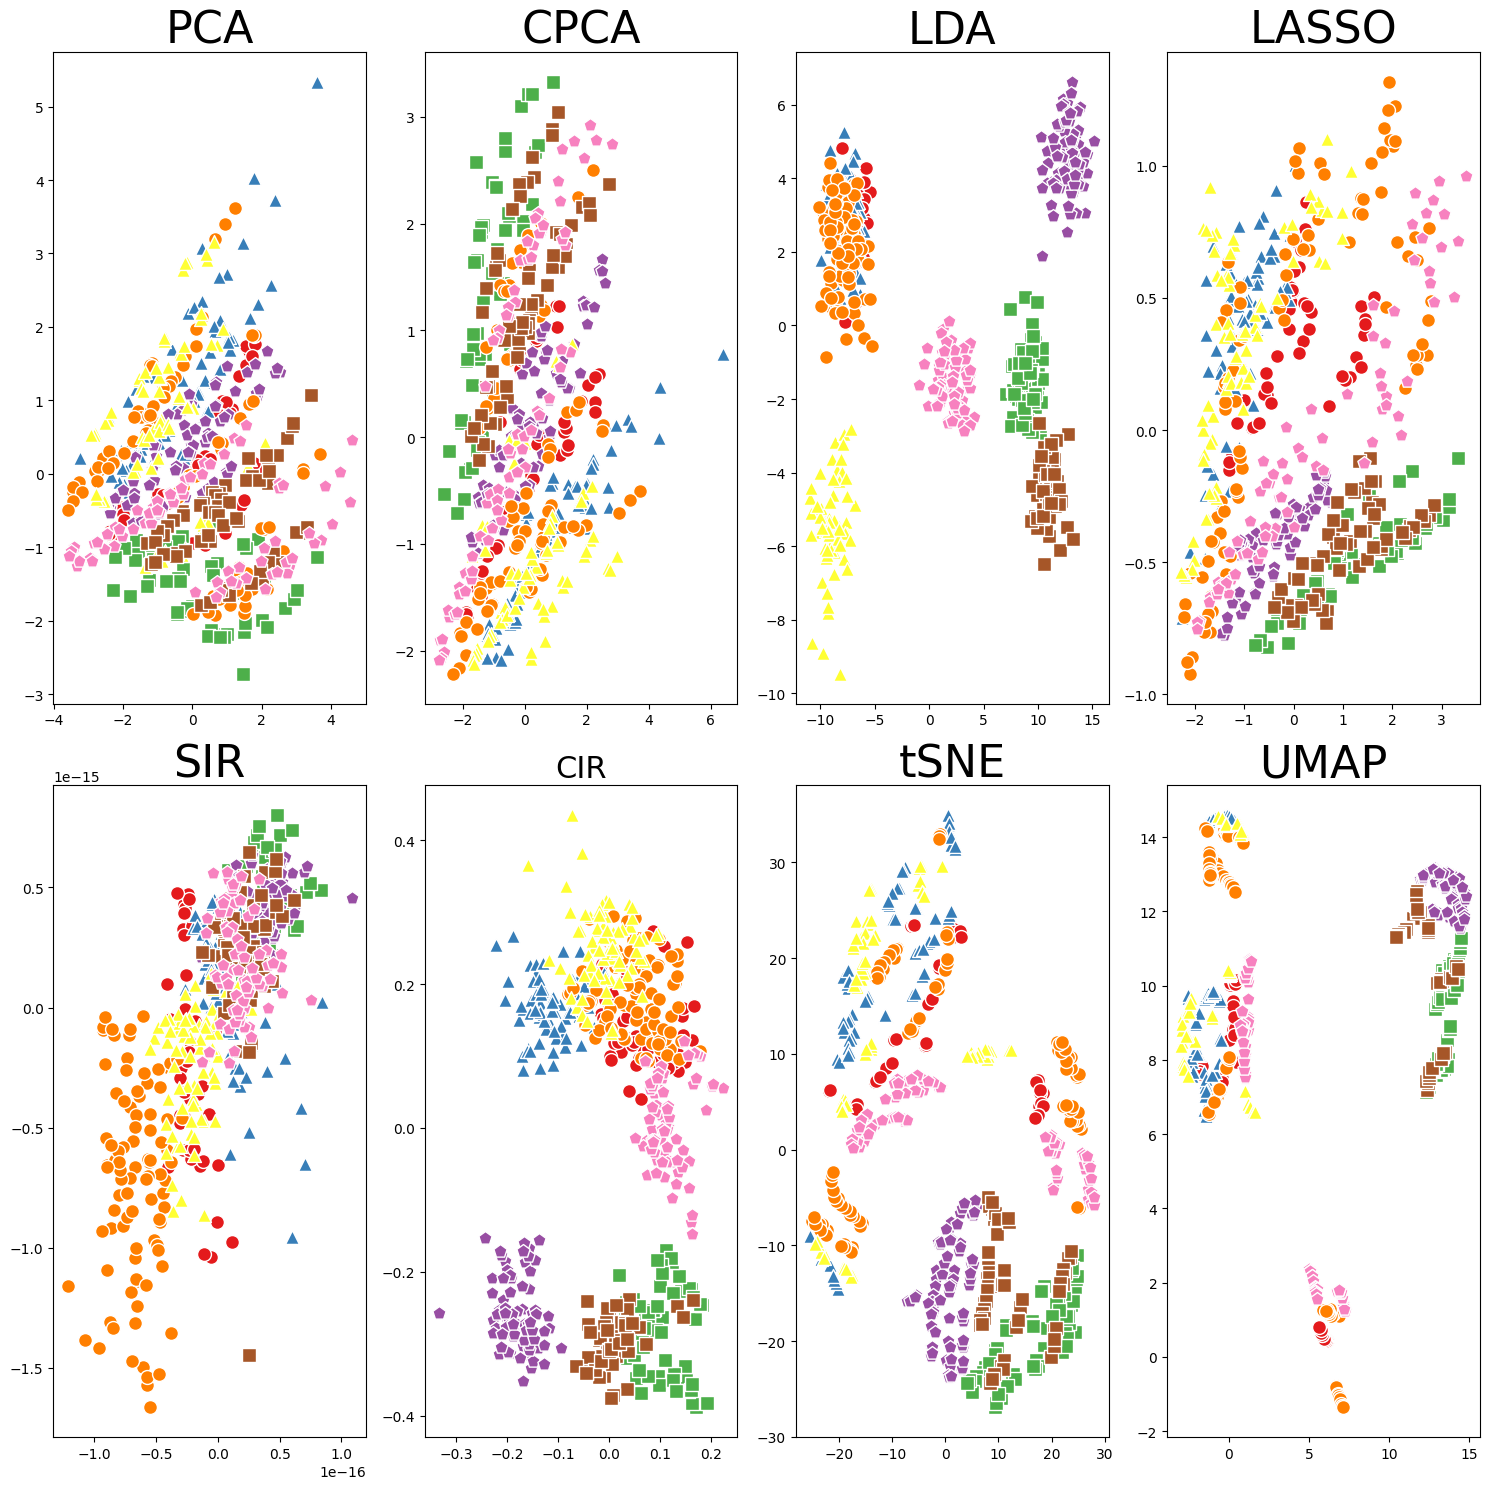

Silhouette scores for raw, PCA, CPCA, LDA, LASSO, SIR, CIR, tSNE, UMAP
  Method  Silhouette Score
0    PCA         -0.106114
1   CPCA         -0.070211
2    LDA          0.416656
3  LASSO         -0.114486
4    SIR         -0.108238
5    CIR          0.267836
6   tSNE          0.005671
7   UMAP          0.024769


In [6]:
import numpy as np
import pandas as pd
import time
import matplotlib
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.metrics import silhouette_score
from scipy.linalg import eig
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import contrastive_inverse_regression
from contrastive_inverse_regression import CIR


data = pd.read_csv(
   'Data_Cortex_Nuclear.csv')


# foreground data
fg = data.dropna()


# foreground label
Y = fg['class']
Y = pd.Categorical(Y)
Y = Y.rename_categories({'c-CS-m': '0', 'c-CS-s': '1', 'c-SC-m': '2', 'c-SC-s': '3',
                        't-CS-m': '4', 't-CS-s': '5', 't-SC-m': '6', 't-SC-s': '7'})
Y = Y.astype(float)
labels = np.unique(Y)      # set of unique foreground labels
L = len(labels)         # number of foreground classes/slices
fg = fg.iloc[:, 1:78]
n = fg.shape[0]  # foreground sample size
X = fg - np.mean(fg, axis=0)
X = X.values


# background data
bg = data[data['Genotype'] == 'Control'].copy()
bg = bg.dropna()


# background label
Yt = bg['Behavior']
Yt = pd.Categorical(Yt)
Yt = Yt.rename_categories({'C/S': '0', 'S/C': '1'})


Yt = Yt.astype(float)
labelst = np.unique(Yt)   # set of unique background labels
Lt = len(labelst)       # number of background classes/slices
bg = bg.iloc[:, 1:78]
m, p = bg.shape


# tuning parameter alpha
alpha = 0.0001
# reduce dimension from 77 to 2 for visualization
d = 2


# np.random.seed(22)      # add seed


# CIR
print("CIR......")
start_time = time.time()


V_CIR = CIR(fg, Y, bg, Yt, alpha, d)
X_CIR = X @ V_CIR


end_time = time.time()



# SIR
print("SIR...")
Sigma_XX = X.T @ X / n
Sigma_X = np.zeros((p, p))
for l in labels:
   X_curr = fg.values[Y == l]
   n_curr = X_curr.shape[0]
   Sigma_X += n_curr * np.outer(X_curr.mean(axis=0) - fg.values.mean(axis=0), X_curr.mean(axis=0) - fg.values.mean(axis=0))


Sigma_X /= n
eigvals, eigvecs = eig(Sigma_XX, Sigma_X)
V_SIR = eigvecs[:, :d]
X_SIR = X @ V_SIR



# PCA
print("PCA...")
pca = PCA(n_components=d)
X_PCA = pca.fit_transform(X)


# CPCA
print("CPCA...")
alpha_CPCA = 2
cov_fg = np.cov(fg.values, rowvar=False)
cov_bg = np.cov(bg.values, rowvar=False)
eigvals, eigvecs = eig(cov_fg - alpha_CPCA * cov_bg)
V_CPCA = eigvecs[:, :d]
X_CPCA = X @ V_CPCA


# t-SNE
print("t-SNE...")
tsne = TSNE(n_components=d)
X_tSNE = tsne.fit_transform(fg.values)


# UMAP
import umap
print("UMAP...")
umap_model = umap.UMAP(n_components=d)
X_UMAP = umap_model.fit_transform(fg.values)


# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
print("LDA...")
lda = LDA(n_components=d)
X_LDA = lda.fit_transform(X, Y)


# # LASSO
print("LASSO...")
lasso = Lasso(alpha=0.1)
lasso.fit(X, Y)
selected_features = np.where(lasso.coef_ != 0)[0][:d]
X_LASSO = X[:, selected_features]




# colors credit to Color Brewer
colors = [[228/255, 26/255, 28/255],
         [55/255, 126/255, 184/255],
         [77/255, 175/255, 74/255],
         [152/255, 78/255, 163/255],
         [255/255, 127/255, 0/255],
         [255/255, 255/255, 51/255],
         [166/255, 86/255, 40/255],
         [247/255, 129/255, 191/255]]


markers = ['o', '^', 's', 'p', 'o', '^', 's', 'p']


fig, axs = plt.subplots(2, 4, figsize=(15, 15))


# Function to plot scatter subplots
def plot_scatter(ax, X, title, fontsize=32):
   for l in range(L):
       X_curr = X[Y == labels[l]]
       ax.scatter(X_curr[:, 0], X_curr[:, 1], 100, color=colors[l], marker=markers[l], label=f'Label {labels[l]}', edgecolors='w')
   ax.set_title(title, fontsize=fontsize)



# Plotting each subplot
plot_scatter(axs[0, 0], X_PCA, 'PCA')
plot_scatter(axs[0, 1], X_CPCA, 'CPCA')
plot_scatter(axs[0, 2], X_LDA, 'LDA')
plot_scatter(axs[0, 3], X_LASSO, 'LASSO')
plot_scatter(axs[1, 0], X_SIR, 'SIR')
plot_scatter(axs[1, 1], X_CIR, 'CIR', fontsize=22)
plot_scatter(axs[1, 2], X_tSNE, 'tSNE')
plot_scatter(axs[1, 3], X_UMAP, 'UMAP')


plt.tight_layout()
plt.show()


print('Silhouette scores for raw, PCA, CPCA, LDA, LASSO, SIR, CIR, tSNE, UMAP')
silhouette_scores = [
   silhouette_score(X_PCA, Y),
   silhouette_score(X_CPCA, Y),
   silhouette_score(X_LDA, Y),
   silhouette_score(X_LASSO, Y),
   silhouette_score(X_SIR, Y),
   silhouette_score(X_CIR, Y),
   silhouette_score(X_tSNE, Y),
   silhouette_score(X_UMAP, Y),
]


methods = ['PCA', 'CPCA', 'LDA', 'LASSO', 'SIR', 'CIR', 'tSNE', 'UMAP']
silhouette_df = pd.DataFrame({
   'Method': methods,
   'Silhouette Score': silhouette_scores,
   # 'Calinski-Harabasz Score': calinski_harabasz_scores
})


print(silhouette_df)
